In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

import utils.torchUtils as gnn

plt.style.use('science')


In [32]:
signal = ObjIter([Tree(fc.eightb.preselection.NMSSM_XYY_YToHH_8b_MX_1000_MY_450),Tree(fc.eightb.preselection.NMSSM_XYY_YToHH_8b_MX_700_MY_300)])
qcd = ObjIter([Tree(fc.eightb.preselection.QCD_B_List)])

In [33]:
import awkward0 as ak0

# mlp_path = "/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-benchmark/x_yy_4h_8b/models/mlp_dijet/output"
gnn_path = "/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-benchmark/x_yy_4h_8b/models/rank_graph_dijet_relp4v2/output"
# gnn_kin_path = "/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-benchmark/x_yy_4h_8b/models/graph_dijet_kin/output"

def load_model_output(path):
    output = ak0.load(path)
    scores = ak.from_awkward0(output['scores'])
    scores = np.asarray(scores).reshape(-1,105)
    return ak.from_numpy(scores)

def load_regex_output(regex):
    print(glob.glob(regex))
    path = glob.glob(regex)[0]
    return load_model_output(path)

In [34]:
import glob 

def load_signal_output(tree):
    mass = tree.sample
    gnn_score = load_regex_output(f"{gnn_path}/*{mass}*")
    tree.extend(gnn_score=gnn_score)
signal.apply(load_signal_output)

['/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-benchmark/x_yy_4h_8b/models/rank_graph_dijet_relp4v2/output/NMSSM_XYY_YToHH_8b_MX_1000_MY_450_accstudies.awkd']
['/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-benchmark/x_yy_4h_8b/models/rank_graph_dijet_relp4v2/output/NMSSM_XYY_YToHH_8b_MX_700_MY_300_accstudies.awkd']


[None, None]

In [35]:
def load_bkg_output(tree):
    gnn_scores = [] 
    for f in tree.filelist:
        gnn_scores.append( load_regex_output(f'{gnn_path}/{f.sample}*') )
    gnn_scores = ak.concatenate(gnn_scores)
    tree.extend(gnn_score=gnn_scores)
qcd.apply(load_bkg_output)

['/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-benchmark/x_yy_4h_8b/models/rank_graph_dijet_relp4v2/output/QCD_bEnriched_HT100to200_TuneCP5_13TeV-madgraph-pythia8.awkd']
['/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-benchmark/x_yy_4h_8b/models/rank_graph_dijet_relp4v2/output/QCD_bEnriched_HT200to300_TuneCP5_13TeV-madgraph-pythia8.awkd']
['/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-benchmark/x_yy_4h_8b/models/rank_graph_dijet_relp4v2/output/QCD_bEnriched_HT300to500_TuneCP5_13TeV-madgraph-pythia8.awkd']
['/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-benchmark/x_yy_4h_8b/models/rank_graph_dijet_relp4v2/output/QCD_bEnriched_HT500to700_TuneCP5_13TeV-madgraph-pythia8.awkd']
['/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-benchmark/x_yy_4h_8b/models/rank_graph_dijet_relp4v2/output/QCD_bEnriched_HT700to1000_TuneCP5_13TeV-madgraph-pythia8.awkd']
['/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-benchmark/x_yy_4h_8b/models/rank_graph_dijet_relp4v2/output/QCD_bEnriched_HT10

[None]

100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


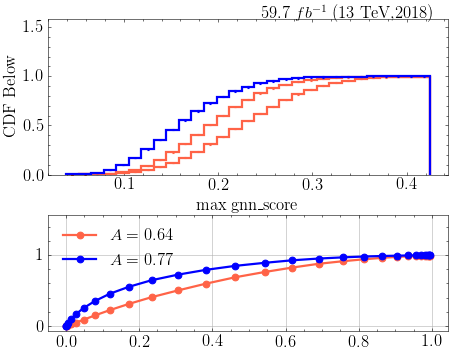

In [36]:
class varmax(ObjTransform):
  def init(self):
    self.xlabel = f'max {self.var}'
  def __call__(self, tree):
    return ak.max(tree[self.var], axis=-1)

study.quick(
  signal+qcd, efficiency=True,
  varlist=[varmax(var='gnn_score')],

  cumulative=1,
  correlation=True,
)